In [2]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)


# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


loading pN_40_0_240.dat
loading pN_40_0_1180.dat
loading pN_40_0_1010.dat
loading pN_40_0_2260.dat
loading pN_40_0_730.dat
loading pN_40_0_380.dat
loading pN_40_0_1390.dat
loading pN_40_0_3120.dat
loading pN_40_0_1920.dat
loading pN_40_0_200.dat
loading pN_40_0_2660.dat
loading pN_40_0_320.dat
loading pN_40_0_450.dat
loading pN_40_0_1640.dat
loading pN_40_0_620.dat
loading pN_40_0_860.dat
loading pN_40_0_280.dat
loading pS_40_0_860.dat
loading pS_40_0_1390.dat
loading pS_40_0_240.dat
loading pS_40_0_3120.dat
loading pS_40_0_1640.dat
loading pS_40_0_280.dat
loading pS_40_0_200.dat
loading pS_40_0_2260.dat
loading pS_40_0_1010.dat
loading pS_40_0_1920.dat
loading pS_40_0_2660.dat
loading pS_40_0_450.dat
loading pS_40_0_730.dat
loading pS_40_0_380.dat
loading pS_40_0_1180.dat
loading pS_40_0_620.dat
loading pS_40_0_320.dat
(512000,)


<IPython.core.display.Javascript object>


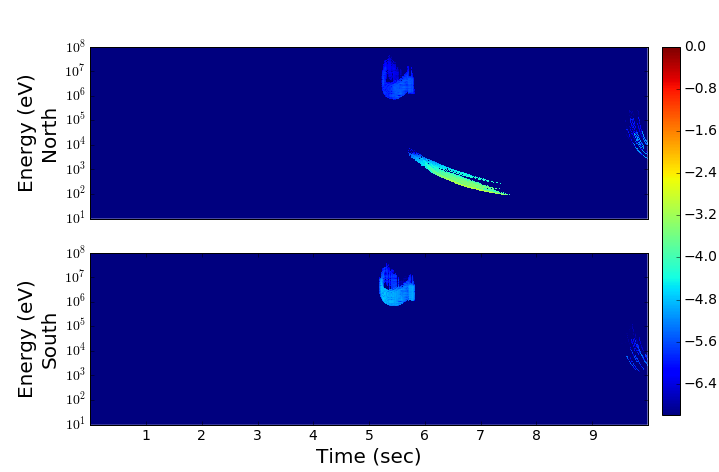

Max N (deg):  0.0715798354206
Max S (deg):  0.00122727773707
15590


In [145]:
out_dir   = '../outputs/test_WIPP_outs/'
out_lat   = 40
out_lon   = 0
out_freq  = 450

N_filename = os.path.join(out_dir, "pN_%d_%d_%d.dat"%(out_lat, out_lon, out_freq))
S_filename = os.path.join(out_dir, "pS_%d_%d_%d.dat"%(out_lat, out_lon, out_freq))
NUM_E = 512;
NUM_TIMES = 1000;
T_MAX = 10
T_STEP = np.floor(T_MAX/NUM_TIMES)
E_MIN = 1e1
E_MAX = 1e8
NUM_E = 512
E_EXP_TOP = np.log10(E_MAX)
E_EXP_BOT = np.log10(E_MIN)
DE_EXP = ((E_EXP_TOP - E_EXP_BOT)/(NUM_E))

tvec = np.linspace(T_STEP,T_MAX,NUM_TIMES)
E_tot_arr = pow(10, (E_EXP_BOT + DE_EXP*np.arange(NUM_E)) ) # energy in eV


clims =[-7, 0]

pN, pS = sum_p_files(out_dir, out_lat, out_lon)
# pN = np.loadtxt(N_filename)
# pS = np.loadtxt(S_filename)

print np.shape(pS)


pN = pN.reshape(NUM_E, NUM_TIMES)
pS = pS.reshape(NUM_E, NUM_TIMES)

pN_P = np.log10(np.sqrt(pN))
np.clip(pN_P,clims[0],clims[1],out=pN_P)

pS_P = np.log10(np.sqrt(pS))
np.clip(pS_P,clims[0],clims[1],out=pS_P)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

p1 = ax1.imshow(pN_P,origin='lower',aspect='auto', interpolation='none')
p1.set_clim(clims)
p2 = ax2.imshow(pS_P,origin='lower',aspect='auto', interpolation='none')
p2.set_clim(clims)

cax = fig.add_axes([0.92, 0.12, 0.025, 0.78])
fig.colorbar(p1,cax=cax)
# Label axes

tlabels = np.arange(1,np.floor(T_MAX))
tinds =  [np.argmax(tt <= tvec) for tt in tlabels]
ax2.set_xticks(tinds)
tlabel_strings = ['%d'%k for k in tlabels]
ax2.set_xticklabels(tlabel_strings)


ax1.get_xaxis().set_visible(False)
#     ax2.set_xticks(np.floor(np.linspace(0,sc.NUM_STEPS-1,sc.T_MAX + 1)))
#     ax2.set_xticklabels(np.floor(tvec[ax2.get_xticks().astype(int)]))

# Label each power of 10
logvals = np.arange(np.log10(E_MIN), np.log10(E_MAX)+1)
einds =  [np.argmax(lv <= np.log10(E_tot_arr)) for lv in logvals]
einds[-1] = NUM_E - 1 

ylabel_strings = ['$10^%d$'%k for k in logvals]
ax1.set_yticks(einds)
ax1.set_yticklabels(ylabel_strings)
ax1.set_ylabel('Energy (eV)\nNorth')
ax2.set_yticks(einds)
ax2.set_yticklabels(ylabel_strings)
ax2.set_ylabel('Energy (eV)\nSouth')
ax2.set_xlabel('Time (sec)')

print "Max N (deg): ", np.max((180./np.pi)*np.sqrt(pN))
print "Max S (deg): ", np.max((180./np.pi)*np.sqrt(pS))

# print np.max(pS_P)
# print np.min(pS_P)
# print np.max(pS)
print sum(sum((pN!=0)))

In [113]:
f1 = 200; f2 = 30000;
flogs = np.linspace(np.log10(f1), np.log10(f2), 32)
flins = np.round(pow(10, flogs)/10.)*10
print flins

[   200.    240.    280.    320.    380.    450.    530.    620.    730.
    860.   1010.   1180.   1390.   1640.   1920.   2260.   2660.   3120.
   3670.   4310.   5070.   5960.   7000.   8230.   9680.  11370.  13370.
  15720.  18470.  21710.  25520.  30000.]


In [141]:
def sum_p_files(out_dir, lat, lon):
    d = os.listdir(out_dir)
    pNfiles = [x for x in d if x.startswith('pN_%d_%d'%(lat, lon))]
    pSfiles = [x for x in d if x.startswith('pS_%d_%d'%(lat, lon))]
        
    pN = None
    for x in pNfiles:
        print "loading %s"%(x)
        tmp = np.loadtxt(os.path.join(out_dir, x))
        if pN is None:
            pN = tmp
        else:
            pN += tmp
            
    pS = None
    for x in pSfiles:
        print "loading %s"%(x)
        tmp = np.loadtxt(os.path.join(out_dir, x))
        if pS is None:
            pS = tmp
        else:
            pS += tmp
    return pN, pS

# out_dir   = '../outputs/test_WIPP_outs/'
# out_lat   = 50
# out_lon   = 0
# out_freq  = 450
# NUM_E = 512;
# NUM_TIMES = 1000;

# sum_p_files('../outputs/test_WIPP_outs/', out_lat, out_lon)



loading pN_50_0_380.dat
loading pN_50_0_1390.dat
loading pN_50_0_730.dat
loading pN_50_0_280.dat
loading pN_50_0_200.dat
loading pN_50_0_860.dat
loading pN_50_0_320.dat
loading pN_50_0_450.dat
loading pN_50_0_1180.dat
loading pN_50_0_620.dat
loading pN_50_0_1010.dat
loading pN_50_0_240.dat
loading pS_50_0_1390.dat
loading pS_50_0_380.dat
loading pS_50_0_450.dat
loading pS_50_0_200.dat
loading pS_50_0_730.dat
loading pS_50_0_280.dat
loading pS_50_0_240.dat
loading pS_50_0_860.dat
loading pS_50_0_320.dat
loading pS_50_0_1180.dat
loading pS_50_0_620.dat
loading pS_50_0_1010.dat


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))